# Working with Data
##### Experts often possess more data than judgement -Colin Powell

In [1]:
%%capture
# To supress the output when calling another file
%run ./GettingData.ipynb
from collections import defaultdict
import dateutil.parser

### Exploring One-Dimensional Data

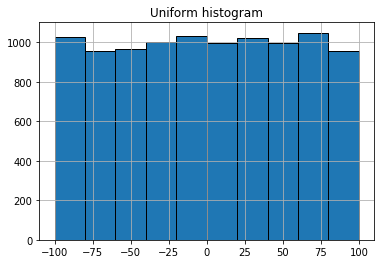

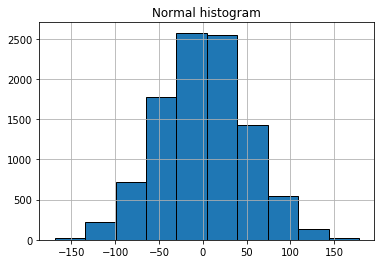

In [2]:
# def bucketsize(point, bucket_size):
#     """floor the point to the next lower multiple of bucket size"""
#     return bucket_size * math.floor(point/bucket_size)

# def make_histograms(points, bucket_size):
#     """buckets the points and counts how many in each bucket"""
#     return Counter(bucketsize(point, bucket_size) for point in points)

# def plot_histogram(points, bucket_size, title=""):
#     histogram = make_histogram(points, bucket_size)
#     plt.bar(histogram.keys(), histogram.value(), width=bucket_size)
#     plt.title(title)
#     plt.show
    
random.seed(0)

# uniform between -100 to 100
uniform = [200*random.random()-100 for _ in range(10000)]

# normal distribution with mean 0 and std 50
normal = [50*inverse_normal_cdf(random.random()) for _ in range(10000)]

[counts, bins, _] = plt.hist(uniform, 10, ec='black') # ec is edge colour
plt.title("Uniform histogram")
plt.grid()
plt.show()

[counts, bins, _] = plt.hist(normal, 10, ec='black') # ec is edge colour
plt.title("Normal histogram")
plt.grid()
plt.show()

### Two dimensions

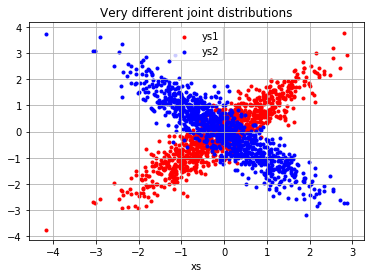

Correlation xs,ys1:  0.9
Correlation xs,ys2:  -0.9


In [3]:
def random_normal():
    """returns a random draw from a normal distribution"""
    return inverse_normal_cdf(random.random())

xs  = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal()/2 for x in xs]
ys2 = [-x + random_normal()/2 for x in xs]

plt.scatter(xs, ys1, marker=".", color="red", label="ys1")
plt.scatter(xs, ys2, marker=".", color="blue", label="ys2")
plt.title("Very different joint distributions")
plt.xlabel("xs")
plt.legend(loc="upper center")
plt.grid()
plt.show()

print("Correlation xs,ys1: ", round(correlation(xs, ys1),1))
print("Correlation xs,ys2: ", round(correlation(xs, ys2),1))

### Many Dimensions

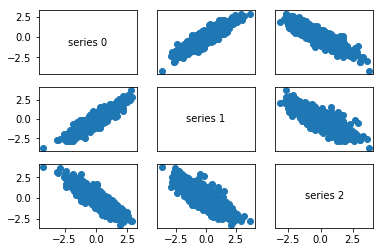

[[1.0, 0.901, -0.892], [0.901, 1.0, -0.807], [-0.892, -0.807, 1.0]]


In [4]:
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i,j)th entry 
    is the correlation between coumns i and j of data"""
    
    _,num_columns = shape(data)
    
    def matrix_entry(i,j):
        return round(correlation(get_column(data,i), get_column(data,j)),3)
   
    return make_matrix(num_columns,num_columns, matrix_entry)

# Plot matrix
def plot_matrix(data):
    _,num_columns = shape(data)
    fig, ax = plt.subplots(num_columns, num_columns)

    for i in range(num_columns):
        for j in range(num_columns):

            # Scatter column j on the x axis vs column i on y-axis
            if i!=j: ax[i][j].scatter(get_column(data,j), get_column(data,i))

            # unless i = j in which case show the series name
            else: ax[i][j].annotate("series "+ str(i),(0.5,0.5),
                                   xycoords="axes fraction",
                                   ha="center", va="center")

            # then hide axis labels except left and bottom charts
            if i < num_columns -1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the top left and bottom right chart axes label which are wrong because they only have text
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][-1].get_ylim())
    plt.show()
    

data = list(map(list, zip(xs,ys1,ys2)))
plot_matrix(data)
print(correlation_matrix(data))

### Cleaning and Munging

In [5]:
def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input_row"""
    
    return [parser(value) if parser is not None else value
           for value, parser in list(zip(input_row, parsers))]

def parse_rows_with(reader, parsers):
    """wraps a reader to apply the parsers to each of its rows"""
    for row in reader:
        yield parse_row(row, parsers)
        
def try_or_none(f):
    """wraps f to return None if f raises an exception
    assumes f takes only 1 input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

# define parse_row with safety net
def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
           for value, parser in list(zip(input_row, parsers))]

data = []
with open("comma_delimited_stock_prices.csv", "r") as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)
        
#  check for None rows
for row in data:
    if any(x is None for x in row):
        print("Empty row from data parsed as list:\n",row, "\n")
        
# similarly for csv.DictReader. The parsers should be supplied as dictionary of {parsers:fieldnames}
def try_parse_field(field_name, value, parser_dict):
    """try to parse value using the appropriate function from parser_dict"""
    parser = parser_dict.get(field_name) # None if no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
def parse_dict(input_dict, parser_dict):
    return {field_name: try_parse_field(field_name, value, parser_dict)
           for field_name, value in input_dict.items()}

data = []

with open("colon_delimited_stock_prices.txt", "r") as f:
    # need header in the file to specify data keys
    reader = csv.DictReader(f, delimiter=":")
    parsers = {"symbol":None, "date":dateutil.parser.parse, "closing_price":float}
    for line in reader:
        data.append(parse_dict(line, parsers))

print("Data parsed as Dictionary:\n", data)

Empty row from data parsed as list:
 [datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None] 

Data parsed as Dictionary:
 [{'symbol': 'AAPL', 'date': datetime.datetime(2014, 6, 20, 0, 0), 'closing_price': 90.91}, {'symbol': 'MSFT', 'date': datetime.datetime(2014, 6, 20, 0, 0), 'closing_price': 41.68}, {'symbol': 'FB', 'date': datetime.datetime(2014, 6, 20, 0, 0), 'closing_price': 64.5}, {'symbol': 'AAPL', 'date': datetime.datetime(2014, 6, 21, 0, 0), 'closing_price': 91.91}, {'symbol': 'MSFT', 'date': datetime.datetime(2014, 6, 21, 0, 0), 'closing_price': 42.68}, {'symbol': 'FB', 'date': datetime.datetime(2014, 6, 21, 0, 0), 'closing_price': 65.5}, {'symbol': 'AAPL', 'date': datetime.datetime(2014, 6, 22, 0, 0), 'closing_price': 89.91}, {'symbol': 'MSFT', 'date': datetime.datetime(2014, 6, 22, 0, 0), 'closing_price': 40.68}, {'symbol': 'FB', 'date': datetime.datetime(2014, 6, 22, 0, 0), 'closing_price': 63.5}]


### Manipulating Data
Suppose in the data we're intereseted in maximum closing price of AAPL. Then we need to:
* Restrict ourselves to AAPL rows
* Grab the closing_price from each such row
* Take max of those prices

In [6]:
max_aapl_price = max([row["closing_price"] for row in data if row["symbol"]=="AAPL"])
print(max_aapl_price)

# similarly if we're interested in highes price of all the stocks. We'll need to group their prices by symbol
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row["symbol"]].append(row) 
    
# Then create a dict list such that key:value are stock:max_price
max_price_by_symbol = {stock: max([data_line["closing_price"] for data_line in value]) 
                       for stock,value in by_symbol.items()}
print(max_price_by_symbol)

# Above we needed to pick out field from dict and also from a list of dicts, so let's make function for this
def picker(field_name):
    """returns a function that picks out field of a dictionary (row) """
    def get_field(row):
        return row[field_name]
    return get_field

def pluck(field_name, rows):
    """turn a list of dicts (like data above) into the list of field_name values"""
    picker_function = picker(field_name)
    return [picker_function(row) for row in rows]

# We can also create a function to group rows by a grouper function
# and optionally apply some sort of value_transform to each group
def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
        
    if value_transform is None:
        return grouped
    else:
        return {key: value_transform(rows)
               for key, rows in grouped.items()}

max_price_by_date = group_by(picker("date"), data, lambda rows: max(pluck("closing_price",rows)))
print(max_price_by_date)


def percent_price_change(yesterday, today):
    return today["closing_price"]/yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # sort rows by values of date
    ordered = sorted(grouped_rows, key=picker("date"))
    
    # zip with an offset to give pairs of consecutive days
    return[{"symbol":today["symbol"],
           "date":today["date"],
           "change":percent_price_change(yesterday, today)}
          for yesterday, today in list(zip(ordered, ordered[1:]))]


# Key is symbol, value is list of "change" dicts
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)
print("\n",changes_by_symbol)

# Collect all "change" dicts into one big list
all_changes = [change for changes in changes_by_symbol.values() 
              for change in changes]
print("\n",all_changes)

# This makes easier to find largest and smallest changes
max(all_changes, key=picker("change"))

# Using all_changes we can compute overall change
def combine_pct_changes(pct_change1, pct_change2):
    return (1+pct_change1)*(1+pct_change2)-1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row: row["date"].month, all_changes, overall_change)

print("\n", overall_change_by_month)

91.91
{'MSFT': 42.68, 'FB': 65.5, 'AAPL': 91.91}
{datetime.datetime(2014, 6, 21, 0, 0): 91.91, datetime.datetime(2014, 6, 22, 0, 0): 89.91, datetime.datetime(2014, 6, 20, 0, 0): 90.91}

 {'MSFT': [{'symbol': 'MSFT', 'date': datetime.datetime(2014, 6, 21, 0, 0), 'change': 0.02399232245681393}, {'symbol': 'MSFT', 'date': datetime.datetime(2014, 6, 22, 0, 0), 'change': -0.04686035613870665}], 'FB': [{'symbol': 'FB', 'date': datetime.datetime(2014, 6, 21, 0, 0), 'change': 0.015503875968992276}, {'symbol': 'FB', 'date': datetime.datetime(2014, 6, 22, 0, 0), 'change': -0.03053435114503822}], 'AAPL': [{'symbol': 'AAPL', 'date': datetime.datetime(2014, 6, 21, 0, 0), 'change': 0.01099989000109991}, {'symbol': 'AAPL', 'date': datetime.datetime(2014, 6, 22, 0, 0), 'change': -0.021760417800021803}]}

 [{'symbol': 'MSFT', 'date': datetime.datetime(2014, 6, 21, 0, 0), 'change': 0.02399232245681393}, {'symbol': 'MSFT', 'date': datetime.datetime(2014, 6, 22, 0, 0), 'change': -0.04686035613870665}, {'s

### Rescaling

In [7]:
# Heights and weights of different people and determine how close each one is to other

# Heights in inch weight in pounds
a_to_b = distance([63, 159], [67, 160]) # 10.77
a_to_c = distance([63, 150], [70, 171]) # 22.14
b_to_c = distance([67, 160], [70, 171]) # 11.40

# Heights in cm weight in pounds
a_to_b = distance([160, 159], [170.2, 160])   # 14.28
a_to_c = distance([160, 150], [177.8, 171])   # 27.53
b_to_c = distance([170.2, 160], [177.8, 171]) # 13.37

# When units are changed B appears to be closer to C than A so data needs to be rescaled to N(0,1)

def scale(data_matrix):
    """returns the means and standard deviations of each column"""
    num_rows, num_cols = shape(data_matrix)
    means  = [mean(get_column(data_matrix,col_i)) 
              for col_i in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix, col_i)) 
              for col_i in range(num_cols)] 
    return means, stdevs

def rescale(data_matrix):
    """rescales the input data so that each column has a mean=0 and stdev=1
    leaves the column unscaled which have stdev=0"""
    means, stdevs = scale(data_matrix)
    num_rows, num_cols = shape(data_matrix)
    def rescaled(i,j):
        if stdevs[j]>0:
            return (data_matrix[i][j] - means[j])/stdevs[j]
        else:
            return data_matrix[i][j]
        
    return make_matrix(num_rows, num_cols, rescaled)

# Usage
data = []
with open("Admission_Predict.csv",'r') as f:
    reader = csv.reader(f, delimiter=",")
    for line in parse_rows_with(reader, [int, int, int, int, float, float, float, int, float]):
        data.append(line)

data = data[1:]
data_rescaled = rescale(data)

### Dimensionality Reduction
It is essential to de-mean the data else dimensionality reduction may likely identify tge mean itself rather than the variation in data

In [8]:
def de_mean_matrix(A):
    num_rows, num_cols = shape(A)
    col_means, _       = scale(A)
    return make_matrix(num_rows, num_cols, lambda i,j: A[i][j]-col_means[j])

def direction(w):
    mag = magnitude(w)
    return [w_i/mag for w_i in w]

def directional_variance_i(x_i,w):
    """the variance of row x_i in the direction determined by w"""
    return dot(x_i, direction(w))**2

def directional_variance(X, w):
    """the sum of variance of data in the direction determined by w"""
    return sum(directional_variance_i(x_i, w) 
               for x_i in X)

# Now we'd like to maximise this variance with respect to w to find first principle component
def directional_variance_gradient_i(x_i, w):
    """the contribution of row x_i to the gradient of the direction-w variance
     or the derivative of directional_variance_i w.r.t w"""
    projection_length = dot(x_i, direction(w))
    return [2*projection_length*x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    """sum of the derivative of directional_variance_i w.r.t. w"""
    return vector_sum(directional_variance_gradient_i(x_i,w) 
                      for x_i in X)


# here there's no "y" so we just pass dummy "y" values
# and target_fn and gradient_fn ignore those values
def first_principle_component_sgd(X,iterations_threshold=10):
    guess       = [0.1 for _ in X[0]] # vector of ones as initial guess for w vector
    target_fn   = lambda x,y,w: directional_variance_i(x,w)
    gradient_fn = lambda x,y,w: directional_variance_gradient_i(x,w)
    dummy_y     = [None for _ in X]
    unscaled_maximizer = maximize_stochastic(target_fn, 
                                             gradient_fn,
                                             X, 
                                             dummy_y,
                                             guess,iterations_threshold)
    return direction(unscaled_maximizer)

Principle component of data: [0.9494968949931462, 0.3137764274103048]


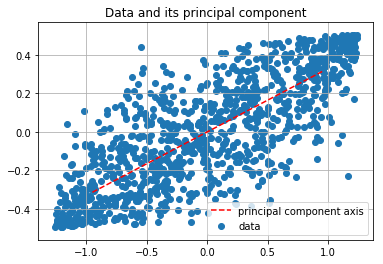

In [21]:
data = []
with open("tab_delimited_correlated_data.txt","r") as f:
    reader = csv.reader(f, delimiter="\t")
    for line in parse_rows_with(reader, [float, float]):
        data.append(line)
        
X=(de_mean_matrix(data))
fpc = first_principle_component_sgd(X,100)
print("Principle component of data:", fpc)
plt.scatter(get_column(X, 0), get_column(X,1),label="data")
plt.plot([-fpc[0],fpc[0]],[-fpc[1],fpc[1]],"--r",label="principal component axis")
plt.title("Data and its principal component")
plt.legend(loc="lower right")
plt.grid()
plt.show()

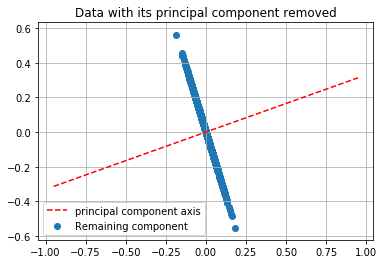

In [22]:
# once we've found the direction that's the first principal component we can project our data onto it

def project(v,w):
    """returns projection of v onto the direction w"""
    projection_length = dot(v,w)
    return scalar_multiply(projection_length, w)

# we can find further components once we remove the projections from the data
def remove_projection_from_vector(v,w):
    """projects v on to w and removes the projection from v"""
    projection_on_w = project(v,w)
    return vector_subtract(v, projection_on_w)

def remove_projection(X,w):
    """for each row of X"""
    return [remove_projection_from_vector(x_i,w) for x_i in X]

X_remaining = remove_projection(X, fpc)
plt.scatter(get_column(X_remaining, 0), get_column(X_remaining,1),label="Remaining component")
plt.plot([-fpc[0],fpc[0]],[-fpc[1],fpc[1]],"--r", label="principal component axis")
plt.title("Data with its principal component removed")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# on a higher dimensional data set, we can iteratively find as many components as we want
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principle_component_sgd(X)
        components.append(component)
        X = remove_projection(X, component)
    return components

# then we can transform our data into lower-dimensional space spanned by the components
def transform_vector(v, components):
    return [dot(v, w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]